# Accurately Modeling Cross-Talk (pass only)

The purpose of this notebook is to provide an example of how a custom pass could model cross-talk noise between qubits in a circuit.

It tests the cross talk pass by showing what happens with extended delays applied in between hadamards.  The pass passes the test, as can be seen below.

First, we need to figure out when different qubits are in parallel delays.

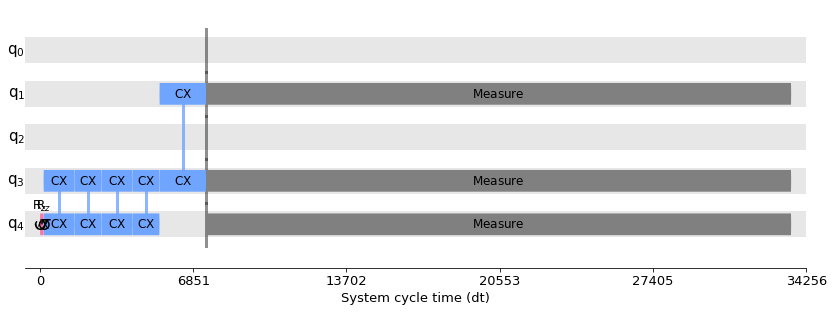

In [1]:
#Visualizing the scheduling of a circuit
from qiskit import QuantumCircuit, transpile, schedule
from qiskit.visualization.timeline import draw
from qiskit.test.mock import FakeVigo #test on FakeVigo (5 qubit simulator)

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()
# qc = QuantumCircuit(3)
# qc.h(0)
# qc.cx(0,1)
# qc.x(1)
# qc.cx(1,2)
# qc.h(2)
# qc.cx(2, 0)
# qc.x(2)
# qc.measure_all()

backend = FakeVigo() #FakeParis
qc = transpile(qc, backend, scheduling_method='alap')
draw(qc)

In [2]:
qc.draw(fold=-1)

┌─────────────────┐                                                         ░ ┌──────────────────┐      
ancilla_0 -> 0 ┤ DELAY(7424[dt]) ├─────────────────────────────────────────────────────────░─┤ DELAY(26160[dt]) ├──────
               ├─────────────────┤                                            ┌───┐        ░ └──────────────────┘   ┌─┐
      q_2 -> 1 ┤ DELAY(5344[dt]) ├────────────────────────────────────────────┤ X ├────────░────────────────────────┤M├
               ├─────────────────┤                                            └─┬─┘        ░ ┌──────────────────┐   └╥┘
ancilla_1 -> 2 ┤ DELAY(7424[dt]) ├──────────────────────────────────────────────┼──────────░─┤ DELAY(26160[dt]) ├────╫─
               └┬────────────────┤                 ┌───┐     ┌───┐              │          ░ └───────┬─┬────────┘    ║ 
      q_1 -> 3 ─┤ DELAY(160[dt]) ├─────────────────┤ X ├──■──┤ X ├──■───────────■──────────░─────────┤M├─────────────╫─
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐┌─────────────────┐ ░         └╥┘         ┌─┐ ║ 
      q_0 -> 4 ────┤ RZ(π/2) ├────┤ √X ├┤ RZ(π/2) ├──■──┤ X ├──■──┤ X ├┤ DELAY(2080[dt]) ├─░──────────╫──────────┤M├─╫─
                   └─────────┘    └────┘└─────────┘     └───┘     └───┘└─────────────────┘ ░          ║          └╥┘ ║ 
       meas: 3/═══════════════════════════════════════════════════════════════════════════════════════╩═══════════╩══╩═
                                                                                                      0           1  2

In [3]:
result_normal = backend.run([qc]).result()
result_normal.get_counts(0)

{'100': 9,
 '110': 12,
 '001': 12,
 '101': 20,
 '111': 443,
 '011': 23,
 '010': 15,
 '000': 490}

Now construct a pass manager and run the predefined pass CrossTalkDelayReplace on the qc2 circuit.

In [4]:
from qiskit.transpiler import PassManager
#local folder/file
from delayPasses.crossTalkPass import CrossTalkDelayReplace

pm = PassManager()
pm.append([CrossTalkDelayReplace(backend.configuration().coupling_map)])
# print(backend.configuration().coupling_map)

out_qc2 = pm.run(qc)
out_qc2.draw(fold=-1)

┌────────────────┐          ┌─────────────────┐                                                           ┌─────────────────┐                                       ░ ┌──────────────────┐      
   q_0: ┤ DELAY(160[dt]) ├─■────────┤ DELAY(5184[dt]) ├──────────────────────────────────────────────────■────────┤ DELAY(2080[dt]) ├───────────────────────────────────────░─┤ DELAY(26160[dt]) ├──────
        ├────────────────┤ │ZZ(0.1) └─────────────────┘                              ┌─────────────────┐ │ZZ(0.1) └─────────────────┘                          ┌───┐        ░ └──────────────────┘   ┌─┐
   q_1: ┤ DELAY(160[dt]) ├─■──────────────■─────────────────────────────────■────────┤ DELAY(5184[dt]) ├─■──────────────■──────────────────────────────────────┤ X ├────────░────────────────────────┤M├
        ├────────────────┤                │ZZ(0.1)     ┌─────────────────┐│ │       │└─────────────────┘                │ZZ(0.1)     ┌─────────────────┐       └─┬─┘        ░ ┌──────────────────┐   └╥┘
   q_2: ┤ DELAY(160[dt]) ├────────────────■────────────┤ DELAY(5184[dt]) ├┤  rzz_ct ├───────────────────────────────────■────────────┤ DELAY(2080[dt]) ├─────────┼──────────░─┤ DELAY(26160[dt]) ├────╫─
        ├────────────────┤                             └─────────────────┘│ │ZZ(0.1)│       ┌───┐                        ┌───┐       └─────────────────┘         │          ░ └───────┬─┬────────┘    ║ 
   q_3: ┤ DELAY(160[dt]) ├────────────────────────────────────────────────┼─■───────┼───────┤ X ├───────────■────────────┤ X ├────────────────■──────────────────■──────────░─────────┤M├─────────────╫─
        └──┬─────────┬───┘  ┌────┐      ┌─────────┐                       │         │       └─┬─┘         ┌─┴─┐          └─┬─┘              ┌─┴─┐       ┌─────────────────┐ ░         └╥┘         ┌─┐ ║ 
   q_4: ───┤ RZ(π/2) ├──────┤ √X ├──────┤ RZ(π/2) ├───────────────────────┼─────────┼─────────■───────────┤ X ├────────────■────────────────┤ X ├───────┤ DELAY(2080[dt]) ├─░──────────╫──────────┤M├─╫─
           └─────────┘      └────┘      └─────────┘                       │         │                     └───┘                             └───┘       └─────────────────┘ ░          ║          └╥┘ ║ 
meas: 3/══════════════════════════════════════════════════════════════════╪═════════╪══════════════════════════════════════════════════════════════════════════════════════════════════╩═══════════╩══╩═
                                                                          │         │                                                                                                  0           1  2

In [5]:
# Run using normal backend
result = backend.run([out_qc2]).result()
##Note: if the circuit is sufficiently complicated, you should see a majority of correct counts
## plus a few scattered incorrect (error) counts
result.get_counts(0)

{'001': 7,
 '110': 15,
 '100': 5,
 '000': 495,
 '010': 17,
 '101': 21,
 '011': 26,
 '111': 438}

In [6]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RZZGate
import qiskit.quantum_info as qi
from qiskit.test.mock import FakeVigo

def test_circuit(coupling_map, theta=0, add_noise=False, delay=10):
    nq = np.max(coupling_map) + 1
    qc = QuantumCircuit(nq)
    qc.h(range(nq))
    qc.barrier(range(nq))
    qc.delay(delay, range(nq))
    if add_noise and coupling_map:
        finished = [] #coupling map has i, j and j, i
        for i, j in coupling_map:
            if [i, j] not in finished:
                qc.rzz(theta, i, j)
                finished.append([i, j])
                finished.append([j, i])
    qc.barrier(range(nq))
    qc.h(range(nq))
    return qc

def test_state(coupling_map, theta=0, add_noise=False):
    qc = test_circuit(coupling_map, theta, add_noise)
    return qi.Statevector.from_int(0, 2 ** qc.num_qubits).evolve(qc)

def test_crosstalk_circuit(backend, theta=0.1):
    coupling_map = backend.configuration().coupling_map
    
    qc = test_circuit(coupling_map=coupling_map, delay=1000)
    qc = transpile(qc, backend, scheduling_method='alap')
    
    pm = PassManager()
    pm.append([CrossTalkDelayReplace(coupling_map, theta)])

    qc = pm.run(qc)
    return qc

def test_crosstalk_state(backend, theta=0.1):
    qc = test_crosstalk_circuit(backend, theta)
    return qi.Statevector.from_int(0, 2 ** qc.num_qubits).evolve(qc)

test_circuit(coupling_map=FakeVigo().configuration().coupling_map, theta=0.1, add_noise=True).draw(fold=-1)

┌───┐ ░ ┌───────────────┐                                         ░ ┌───┐
q_0: ┤ H ├─░─┤ DELAY(10[dt]) ├─■───────────────────────────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤ │ZZ(0.1)                                ░ ├───┤
q_1: ┤ H ├─░─┤ DELAY(10[dt]) ├─■─────────■─────────■───────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤           │ZZ(0.1)  │                   ░ ├───┤
q_2: ┤ H ├─░─┤ DELAY(10[dt]) ├───────────■─────────┼───────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤                     │ZZ(0.1)            ░ ├───┤
q_3: ┤ H ├─░─┤ DELAY(10[dt]) ├─────────────────────■─────────■─────────░─┤ H ├
     ├───┤ ░ ├───────────────┤                               │ZZ(0.1)  ░ ├───┤
q_4: ┤ H ├─░─┤ DELAY(10[dt]) ├───────────────────────────────■─────────░─┤ H ├
     └───┘ ░ └───────────────┘                                         ░ └───┘

In [7]:
test_crosstalk_circuit(backend=FakeVigo()).draw(fold=-1)

┌─────────┐┌────┐┌─────────┐ ░ ┌─────────────────┐                                          ░ ┌─────────┐┌────┐┌─────────┐
q_0: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├─■────────────────────────────────────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     ├─────────┤├────┤├─────────┤ ░ ├─────────────────┤ │ZZ(0.1)                                 ░ ├─────────┤├────┤├─────────┤
q_1: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├─■─────────■──────────■───────────────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     ├─────────┤├────┤├─────────┤ ░ ├─────────────────┤           │ZZ(0.1) │ │       │           ░ ├─────────┤├────┤├─────────┤
q_2: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├───────────■────────┤  rzz_ct ├───────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     ├─────────┤├────┤├─────────┤ ░ ├─────────────────┤                    │ │ZZ(0.1)│           ░ ├─────────┤├────┤├─────────┤
q_3: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├────────────────────┼─■───────┼─■─────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     ├─────────┤├────┤├─────────┤ ░ ├─────────────────┤                    │         │ │ZZ(0.1)  ░ ├─────────┤├────┤├─────────┤
q_4: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1000[dt]) ├────────────────────┼─────────┼─■─────────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├
     └─────────┘└────┘└─────────┘ ░ └─────────────────┘                    │         │           ░ └─────────┘└────┘└─────────┘

## Verification of crosstalk pass via probability testing

The following code generates test circuits both from the pass itself and a hardcoded representation of what it should be producing.  The hardcoded circuit acts as a verification that the pass's post-transpiled circuit produces correct oscillating probabilities.

The probabilities oscillate because..... todo :/ (get a better understanding)


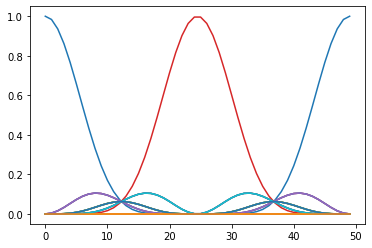

In [8]:
import matplotlib.pyplot as plt

backend = FakeVigo()
coupling_map = backend.configuration().coupling_map
states = [test_state(coupling_map, theta, True) for theta in np.linspace(0, 2 * np.pi, 50)]
probs = np.array([psi.probabilities() for psi in states]).T
for p in probs:
    plt.plot(p)

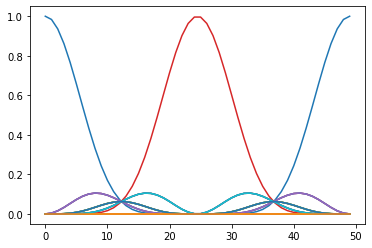

In [9]:
states_crosstalk = [test_crosstalk_state(backend, theta) for theta in np.linspace(0, 2 * np.pi, 50)]
probs_crosstalk = np.array([psi.probabilities() for psi in states_crosstalk]).T
for p in probs_crosstalk:
    plt.plot(p)

## Check the delays to check for damping